<a href="https://colab.research.google.com/github/saqlainkazi690/Projects/blob/main/ml_hackathon_wavez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For effective comparison of solutions you need to reshape all the images in the provided dataset to 224 x 224 x 3 .
The desired compression ratio should be at least 300 times. This requirement translates to the size of about 500 dimensional latent feature space.
MSE loss between actual and reconstructed image will be considered as the metric for the competition.

##Dataset Loading

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        for dir in root_dir:
            self.image_files += [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image = Image.open(image_file).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


dataset = ImageDataset(root_dir=["/kaggle/input/waves-paired/Paired/underwater_scenes/trainB","/kaggle/input/unpaired-wavez/Unpaired/trainB","/kaggle/input/unpaired-wavez/Unpaired/trainA"], transform=transform)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
i=1
for image in train_loader:
   if i==1:
        print(image.shape)
        break

torch.Size([32, 3, 224, 224])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Model 1 - GAN

In [ ]:
images = os.listdir(dataset)
image_files = [f for f in images if f.endswith('.jpg') or f.endswith('.JPEG')]
print(len(image_files))

In [ ]:
image_files_ = image_files[:1000]
print(len(image_files_))

In [ ]:
from PIL import Image
image_arrays = []
for image_file in image_files_:
  image_path = os.path.join(dataset, image_file)
  image = Image.open(image_path)
  image_array = np.array(image)
  image_arrays.append(image_array)

In [ ]:
import cv2
resized_image_arrays = []
for image_array in image_arrays:
  resized_image_array = cv2.resize(image_array, (224, 224))
  resized_image_arrays.append(resized_image_array)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import mean_squared_error

def build_generator(latent_dim, image_shape):
    model = models.Sequential()
    model.add(layers.Dense(64, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(np.prod(image_shape), activation='sigmoid'))
    model.add(layers.Reshape(image_shape))
    return model


def build_discriminator(image_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=image_shape))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
height = 224
width=224
channels=3

image_shape = (height, width, channels)
discriminator = build_discriminator(image_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

latent_dim = 200
generator = build_generator(latent_dim, image_shape)


discriminator.trainable = False
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

compressed_images = generator.predict(noise)
total_batches = len(resized_image_arrays) // batch_size

epochs = 10
batch_size = 32
total_batches = len(resized_image_arrays) // batch_size
compressed_images = []

for epoch in range(epochs):
    for batch in range(total_batches):
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        real_images = resized_image_arrays[batch * batch_size: (batch + 1) * batch_size]
        combined_images = np.concatenate([real_images, generated_images])
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)
        discriminator_loss = discriminator.train_on_batch(combined_images, labels)


        if batch == total_batches - 1:
            remaining_samples = len(resized_image_arrays) - total_batches * batch_size
            if remaining_samples > 0:
                noise = np.random.normal(0, 1, size=(remaining_samples, latent_dim))
                generated_images = generator.predict(noise)
                compressed_images.append(generated_images)

        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        misleading_labels = np.zeros((batch_size, 1))
        generator_loss = gan.train_on_batch(noise, misleading_labels)

    print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")


compressed_images = np.concatenate(compressed_images)


1/1 [==============================] - 0s 95ms/step
Epoch 1/10, Discriminator Loss: 0.6925747990608215, Generator Loss: 0.7084413170814514
1/1 [==============================] - 0s 19ms/step
Epoch 2/10, Discriminator Loss: 0.6922683715820312, Generator Loss: 0.7210877537727356
1/1 [==============================] - 0s 16ms/step
Epoch 3/10, Discriminator Loss: 0.6918465495109558, Generator Loss: 0.73077392578125
1/1 [==============================] - 0s 16ms/step
Epoch 4/10, Discriminator Loss: 0.6918434500694275, Generator Loss: 0.7368994355201721
1/1 [==============================] - 0s 16ms/step
Epoch 5/10, Discriminator Loss: 0.6918154358863831, Generator Loss: 0.7406487464904785
1/1 [==============================] - 0s 16ms/step
Epoch 6/10, Discriminator Loss: 0.6916632056236267, Generator Loss: 0.7423818707466125
1/1 [==============================] - 0s 16ms/step
Epoch 7/10, Discriminator Loss: 0.6919671893119812, Generator Loss: 0.743553638458252
1/1 [=========================

## Model 2 - Deep CNN Autoencoder (with LeakyReLU and latent space size 500)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()


        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 500),
        )


        self.decoder = nn.Sequential(
            nn.Linear(500, 128 * 28 * 28),
            nn.Unflatten(1, (128, 28, 28)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
def train(train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0


        model.train()
        for data in train_loader:
            images = data.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)


        model.eval()
        with torch.no_grad():
            for data in val_loader:
                images = data.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)
            val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return train_losses, val_losses

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def visualize_reconstructions(dataloader):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images = data.to(device)
            outputs = model(images)
            break

    plt.figure(figsize=(10, 5))
    for i in range(0,3):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title('Original')
        ax.axis('off')

        ax = plt.subplot(2, 3, i+4)
        plt.imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title('Reconstructed')
        ax.axis('off')
    plt.show()

### Results for Model 2

Epoch 1, Train Loss: 0.1663, Val Loss: 0.0979
Epoch 2, Train Loss: 0.0833, Val Loss: 0.0728
Epoch 3, Train Loss: 0.0674, Val Loss: 0.0610
Epoch 4, Train Loss: 0.0563, Val Loss: 0.0524
Epoch 5, Train Loss: 0.0503, Val Loss: 0.0471
Epoch 6, Train Loss: 0.0454, Val Loss: 0.0426
Epoch 7, Train Loss: 0.0414, Val Loss: 0.0402
Epoch 8, Train Loss: 0.0379, Val Loss: 0.0375
Epoch 9, Train Loss: 0.0349, Val Loss: 0.0343
Epoch 10, Train Loss: 0.0321, Val Loss: 0.0316
Epoch 11, Train Loss: 0.0303, Val Loss: 0.0301
Epoch 12, Train Loss: 0.0276, Val Loss: 0.0285
Epoch 13, Train Loss: 0.0261, Val Loss: 0.0273
Epoch 14, Train Loss: 0.0245, Val Loss: 0.0262
Epoch 15, Train Loss: 0.0236, Val Loss: 0.0261
Epoch 16, Train Loss: 0.0216, Val Loss: 0.0244
Epoch 17, Train Loss: 0.0204, Val Loss: 0.0238
Epoch 18, Train Loss: 0.0199, Val Loss: 0.0231
Epoch 19, Train Loss: 0.0195, Val Loss: 0.0213
Epoch 20, Train Loss: 0.0186, Val Loss: 0.0215
Epoch 21, Train Loss: 0.0176, Val Loss: 0.0201
Epoch 22, Train Loss: 

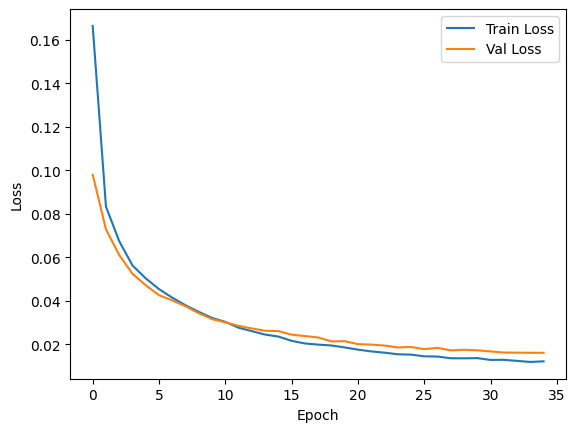

In [ ]:
train_loss, val_loss = train(train_loader,val_loader)
plot_losses(train_loss, val_loss)
visualize_reconstructions(val_loader)

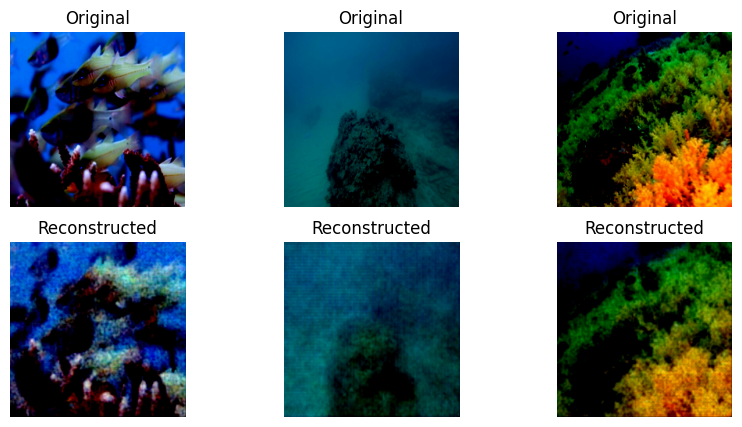

In [ ]:
visualize_reconstructions(val_loader)

## Model 3 - Model 2 with Perceptual Loss

In [ ]:
from torchvision.models import vgg16


In [ ]:
vgg16_model = vgg16(pretrained=True).features[:16].to(device)
for param in vgg16_model.parameters():
    param.requires_grad = False

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg_model = vgg16_model
        self.mse_loss = nn.MSELoss()

    def forward(self, output, target):
        vgg_output = self.vgg_model(output)
        vgg_target = self.vgg_model(target.detach())
        perceptual_loss = self.mse_loss(vgg_output, vgg_target)
        return perceptual_loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s]  


## Model 4 - Deep CNN Autoencoder with Skip Connections and LeakyReLU
 Latent Space size 500

 MSE LOSS = 0.004.

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()


        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_relu1 = nn.LeakyReLU()

        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_relu2 = nn.LeakyReLU()

        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)
        self.encoder_relu3 = nn.LeakyReLU()

        self.flatten = nn.Flatten()
        self.encoder_fc = nn.Linear(128 * 28 * 28, 500)


        self.decoder_fc = nn.Linear(500, 128 * 28 * 28)
        self.unflatten = nn.Unflatten(1, (128, 28, 28))

        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(64)
        self.decoder_relu1 = nn.LeakyReLU()

        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(32)
        self.decoder_relu2 = nn.LeakyReLU()

        self.decoder_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x1 = self.encoder_conv1(x)
        x1 = self.encoder_bn1(x1)
        x1 = self.encoder_relu1(x1)

        x2 = self.encoder_conv2(x1)
        x2 = self.encoder_bn2(x2)
        x2 = self.encoder_relu2(x2)

        x3 = self.encoder_conv3(x2)
        x3 = self.encoder_bn3(x3)
        x3 = self.encoder_relu3(x3)

        encoded = self.flatten(x3)
        encoded = self.encoder_fc(encoded)

        decoded = self.decoder_fc(encoded)
        decoded = self.unflatten(decoded)


        decoded = decoded + x3
        decoded = self.decoder_conv1(decoded)
        decoded = self.decoder_bn1(decoded)
        decoded = self.decoder_relu1(decoded)

        decoded = decoded + x2

        decoded = self.decoder_conv2(decoded)
        decoded = self.decoder_bn2(decoded)
        decoded = self.decoder_relu2(decoded)

        decoded = decoded + x1

        decoded = self.decoder_conv3(decoded)

        return decoded


In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters())

In [ ]:
train_losses, val_losses = train(train_loader, val_loader)


Epoch 1, Train Loss: 0.0674, Val Loss: 0.0114
Epoch 2, Train Loss: 0.0114, Val Loss: 0.0066
Epoch 3, Train Loss: 0.0087, Val Loss: 0.0049
Epoch 4, Train Loss: 0.0067, Val Loss: 0.0039
Epoch 5, Train Loss: 0.0063, Val Loss: 0.0029
Epoch 6, Train Loss: 0.0059, Val Loss: 0.0031
Epoch 7, Train Loss: 0.0054, Val Loss: 0.0026
Epoch 8, Train Loss: 0.0056, Val Loss: 0.0032
Epoch 9, Train Loss: 0.0054, Val Loss: 0.0025
Epoch 10, Train Loss: 0.0048, Val Loss: 0.0019
Epoch 11, Train Loss: 0.0047, Val Loss: 0.0025
Epoch 12, Train Loss: 0.0047, Val Loss: 0.0026
Epoch 13, Train Loss: 0.0050, Val Loss: 0.0021
Epoch 14, Train Loss: 0.0046, Val Loss: 0.0017
Epoch 15, Train Loss: 0.0047, Val Loss: 0.0020
Epoch 16, Train Loss: 0.0046, Val Loss: 0.0018
Epoch 17, Train Loss: 0.0041, Val Loss: 0.0012
Epoch 18, Train Loss: 0.0042, Val Loss: 0.0015
Epoch 19, Train Loss: 0.0040, Val Loss: 0.0025
Epoch 20, Train Loss: 0.0041, Val Loss: 0.0010


In [ ]:
def visualize_reconstructions(dataloader):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images = data.to(device)
            outputs = model(images)
            break

    plt.figure(figsize=(10, 5))
    for i in range(0,3):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title('Original')
        ax.axis('off')

        ax = plt.subplot(2, 3, i+4)
        plt.imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        ax.set_title('Reconstructed')
        ax.axis('off')
    plt.show()

In [ ]:
def visualize_reconstructions_withlatent(dataloader):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images = data.to(device)
            outputs = model(images)
            latent_repr = model.encoder_fc(model.flatten(model.encoder_relu3(model.encoder_bn3(model.encoder_conv3(model.encoder_relu2(model.encoder_bn2(model.encoder_conv2(model.encoder_relu1(model.encoder_bn1(model.encoder_conv1(images)))))))))))  # Get the latent representation
            break

    plt.figure(figsize=(10, 5))
    for i in range(3):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(latent_repr[i].reshape(20,25).cpu().numpy(), cmap='viridis')
        ax.set_title('Latent Representation')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

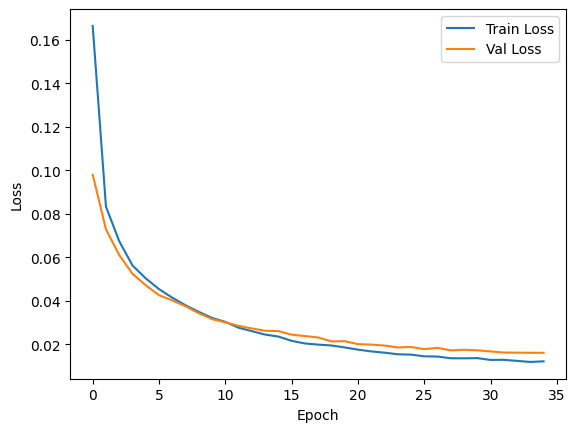

In [ ]:
plot_losses(train_loss, val_loss)

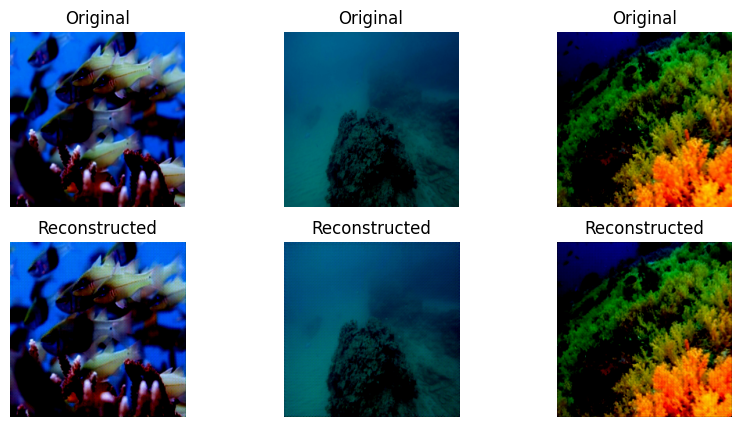

In [ ]:
visualize_reconstructions(val_loader)

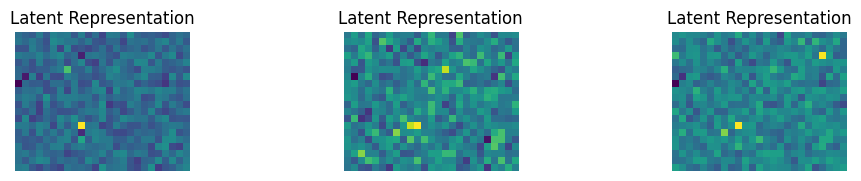

In [ ]:
visualize_reconstructions_withlatent(val_loader)

In [ ]:
torch.save(model.state_dict, "model.pth")